## Educational Recommender System
---

Dataset: [Open University Learning Analytics dataset](https://analyse.kmi.open.ac.uk/open_dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

path = os.path.join("drive", "MyDrive")
path += "/"
print(path)
# path = ""

drive/MyDrive/


In [5]:
# load csv files into dataframes
assessments_df = pd.read_csv(path + 'data/assessments.csv')
courses_df = pd.read_csv(path + 'data/courses.csv')
student_assessment_df = pd.read_csv(path + 'data/studentAssessment.csv')
student_info_df = pd.read_csv(path + 'data/studentInfo.csv')
student_reg_df = pd.read_csv(path + 'data/studentRegistration.csv')
student_vle_df = pd.read_csv(path + 'data/studentVle.csv')
vle_df = pd.read_csv(path + 'data/vle.csv')

In [6]:
unique_vle_resources = vle_df['id_site'].unique()
unique_vle_resources.shape

(6364,)

In [7]:
# assessments_df, test_assessments_df = train_test_split(assessments_df, test_size=0.2, random_state=42)
# courses_df, test_courses_df = train_test_split(courses_df, test_size=0.2, random_state=42)
# student_assessment_df, test_student_assessment_df = train_test_split(student_assessment_df, test_size=0.2, random_state=42)
# student_info_df, test_student_info_df = train_test_split(student_info_df, test_size=0.2, random_state=42)
# student_reg_df, test_student_reg_df = train_test_split(student_reg_df, test_size=0.2, random_state=42)
# student_vle_df, test_student_vle_df = train_test_split(student_vle_df, test_size=0.2, random_state=42)
# vle_df, test_vle_df = train_test_split(vle_df, test_size=0.2, random_state=42)

In [8]:
student_vle_df['id_site'].unique().shape

(6268,)

In [9]:
assessments_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### Removing Bias

We need to remove certain columns in the student dataset so that recommendations out of our recommender system are not biased in any way.

We will definitely be removing
- Gender
- Region

We will be testing
- Age
- Economic Land
- Previous Attempts
- Disability
- Number of Credits in the modules

In [10]:
student_info_df.drop(inplace=True, columns=['gender', 'region'])
student_info_df.head()

,code_module,code_presentation,id_student,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [11]:
# divide the courses into B and J categories based on "code_presentation" because the structure of these
# presentations is different

# student_vle_df = pd.merge(student_vle_df, vle_df, on='id_site')

# * Pre processing Assessments
courses_B_df = courses_df[courses_df['code_presentation'].str.contains('B')]
courses_J_df = courses_df[courses_df['code_presentation'].str.contains('J')]

# * Pre processing Assessments
student_assessment_df = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
student_assessment_df = pd.get_dummies(student_assessment_df, columns=["assessment_type", "code_presentation"])
assessments_df.dropna(how='any', inplace=True)
assessments_df = pd.get_dummies(assessments_df, columns=["assessment_type"])
assessments_df["date"] = [int(date / 7) for date in assessments_df["date"]]
assessments_B_df = assessments_df[assessments_df['code_module'].isin(courses_B_df['code_module'])]
assessments_J_df = assessments_df[assessments_df['code_module'].isin(courses_J_df['code_module'])]

# * Pre processing VLE Dataset
# ! This gets rid of the records with no week_from and week_to values
# ! However, we are not sure if this is the right way to handle this
# * Maybe we can use the student VLE interactions to fill in the missing values

vle_df.drop(columns=['week_from', 'week_to'], inplace=True)
vle_df = pd.get_dummies(vle_df, columns=["activity_type"])
vle_B_df = vle_df[vle_df['code_module'].isin(courses_B_df['code_module'])]
vle_J_df = vle_df[vle_df['code_module'].isin(courses_J_df['code_module'])]


# * Pre processing Student Info Dataset
student_info_df.dropna(how='any', inplace=True)
student_info_df = pd.get_dummies(student_info_df, columns=["highest_education", "imd_band", "age_band", "disability", "final_result"])
student_info_B_df = student_info_df[student_info_df['code_module'].isin(courses_B_df['code_module'])]
student_info_J_df = student_info_df[student_info_df['code_module'].isin(courses_J_df['code_module'])]

In [12]:
def get_vle_interaction_by_site(id_site):
    """
    Returns the student vle interaction for a given site id
    """
    df = pd.DataFrame()
    df = student_vle_df[student_vle_df['id_site'] == id_site]
    return df

def get_vle_interaction_by_student(student_id):
    """
    Returns the student vle interaction for a given student id
    """
    return student_vle_df[student_vle_df['id_student'] == student_id]

def get_student_assessment_scores(student_id):
    """
    Returns the student assessment scores for a given student id
    """
    df = pd.DataFrame()
    df = student_assessment_df[student_assessment_df['id_student'] == student_id]
    return df

def get_unique_vle_sites():
    return student_vle_df['id_site'].unique()

def calculate_euclidean_distance_student(student_id):
    """
    Returns the euclidean distance between the student and all other students
    """
    student = student_info_df[student_info_df['id_student'] == student_id]
    student = student.drop(columns=['id_student'])
    student = student.values
    students = student_info_df.drop(columns=['id_student', 'code_module', 'code_presentation'])
    students = students.values
    return np.linalg.norm(students - student, axis=1)



In [13]:
student_info_B_df.shape

(30757, 29)

### Data Exploration

We need to find trends in students' engagement with the VLE and their test scores (indication of proficiency in a topic).It would appear that  

In [14]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
# find a correlation between VLE Clicks and Student assesments

def get_clicks_for_id_site_by_student(id_site, student_vle_interaction):
    """
    Returns the number of clicks for a given site id
    """
    return student_vle_interaction[student_vle_interaction['id_site'] == id_site].sum()["sum_click"]

def get_weighted_average_score(student_id):
    """
    Returns the weighted average score for a given student
    """
    assessment_scores = get_student_assessment_scores(student_id)
    assessment_scores = pd.merge(assessment_scores, assessments_B_df, on='id_assessment')
    average_score = 0
    for index, row in assessment_scores.iterrows():
        average_score += (row["weight_x"] / 100) * row["score"]
    sum_assessment_weights = assessment_scores["weight_x"].sum()
    average_score = average_score / sum_assessment_weights
    return average_score

def corr_clicks_assessments():
    """
    Displays the correlation between VLE Clicks and Student assesments

    ! Caution: We are only analyzing the B presentations for now
    """
    clicks_assessment_scores_df = pd.DataFrame()

    SAMPLE_SIZE = 1000

    for index, student in tqdm(student_info_B_df.sample(n=SAMPLE_SIZE).iterrows(), total=SAMPLE_SIZE, desc="Processing Students"):
        assessment_scores = get_student_assessment_scores(student["id_student"])
        student_vle_interaction = get_vle_interaction_by_student(student["id_student"])

        assessment_scores = pd.merge(assessment_scores, assessments_B_df, on='id_assessment')

        sum_clicks_per_student = 0
        for id_site in student_vle_interaction["id_site"].unique():
            clicks = get_clicks_for_id_site_by_student(id_site, student_vle_interaction)
            sum_clicks_per_student += clicks

        average_score = 0
        for index, row in assessment_scores.iterrows():
            average_score += (row["weight_x"] / 100) * row["score"]
        sum_assessment_weights = assessment_scores["weight_x"].sum()
        average_score = average_score / sum_assessment_weights
        new_row = pd.DataFrame({"sum_clicks": [sum_clicks_per_student], "average_score": [average_score]})
        if (sum_clicks_per_student < 1500):
            clicks_assessment_scores_df = pd.concat([clicks_assessment_scores_df, new_row], ignore_index=True)

    # fit a least squares line
    X = clicks_assessment_scores_df["sum_clicks"].values.reshape(-1, 1)
    y = clicks_assessment_scores_df["average_score"].values.reshape(-1, 1)

    # drop NaN values from y and drop the corresponding x values

    nan_indices = np.isnan(y)

    X = X[~nan_indices]
    y = y[~nan_indices]

    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    model = LinearRegression().fit(X, y)
    m = model.coef_[0][0]
    b = model.intercept_[0]

    plt.scatter(clicks_assessment_scores_df["sum_clicks"], clicks_assessment_scores_df["average_score"])
    plt.plot(X, m * X + b, color='red')
    plt.xlabel("Sum Clicks")
    plt.ylabel("Average Score")
    plt.title("Correlation between Sum Clicks and Average Score")
    plt.show()

    correlation_clicks_average_score = clicks_assessment_scores_df["sum_clicks"].corr(clicks_assessment_scores_df["average_score"])
    print(f"Correlation between Sum Clicks and Average Score: {correlation_clicks_average_score}")



# corr_clicks_assessments()

### Clicks vs Type of Content

We needed to see if the sum_clicks differ drastically based on content type in the VLE. It would appear that it does. There seems to be steep difference in the sum_clicks on "oucontent" type vs something like "dataplus". OUContent appears to be content embedded within the Open University VLE itself and the abnormally large sum_clicks could be due to a tracking deficit in other activity types.  

In [15]:
# Get distribution of clicks by type of activity

def show_clicks_by_type():
    """
    Displays the distribution of clicks by type of activity
    """
    global student_vle_df
    merged_vle = pd.merge(student_vle_df, vle_df, on='id_site')
    # print(merged_vle.head())
    activity_names = merged_vle.columns[10:]
    activity_names = pd.Series(activity_names)
    for i in range(len(activity_names)):
        activity_names[i] = activity_names[i].replace("activity_type_", "")
    clicks_by_type = np.zeros(shape=(len(activity_names), 1))

    # Add clicks to clicks by type based on which activity column has True
    activity_columns = merged_vle.columns[10:]
    clicks_by_type = merged_vle[activity_columns].multiply(merged_vle["sum_click"], axis="index").sum(axis=0).values
    clicks_by_type = pd.DataFrame(clicks_by_type, index=activity_names, columns=["sum_click"])

    clicks_by_type.plot(kind='bar')
    plt.xlabel("Activity Type")
    plt.ylabel("Sum Clicks")
    plt.title("Distribution of Clicks by Type of Activity")
    plt.show()

# show_clicks_by_type()

In [16]:
# Get how many of each resource is there
def get_resource_distribution():
    """
    Returns the distribution of resources
    """

    global student_vle_df
    # student_vle_df = pd.merge(student_vle_df, vle_df, on='id_site')
    merged_vle = pd.merge(student_vle_df, vle_df, on='id_site')
    activity_names = merged_vle.columns[10:]
    activity_names = pd.Series(activity_names)
    for i in range(len(activity_names)):
        activity_names[i] = activity_names[i].replace("activity_type_", "")

    activity_vectors = np.array(merged_vle.iloc[:, 10:], dtype=np.float64)
    clicks_by_type = activity_vectors.sum(axis=0)
    clicks_by_type = pd.DataFrame(clicks_by_type, index=activity_names, columns=["sum_click"])
    clicks_by_type.plot(kind='bar')
    plt.xlabel("Activity Type")
    plt.ylabel("Sum Clicks")
    plt.title("Distribution of Clicks by Type of Activity")
    plt.show()

# get_resource_distribution()

In [17]:
from sklearn.linear_model import LinearRegression
import datetime
import numpy as np

# Get sucessful student ids
def get_student_assessment_trends_slope(student_info_dataframe):
    """
    Returns the ids of successful students
    Currently the heuristic is to find students with a positive slope in their assessment scores
    The slope threshold currently is 0.05 because that is the 75th percentile of the slope distribution
    """
    # plot student assessment trends
    student_assessment_df_merged = pd.merge(student_assessment_df, assessments_df, on='id_assessment')
    student_trend_df = pd.DataFrame()

    for index, student in tqdm(student_info_dataframe.iterrows(), total=student_info_dataframe.shape[0], desc="Processing Students"):
        student_scores = get_student_assessment_scores(student["id_student"])

        if (student_scores.empty):
            continue

        student_scores = student_scores.dropna(how='any', inplace=False)

        # calculate a linear regression line for the student scores
        x = student_scores["date"].values.reshape(-1, 1)
        y = student_scores["score"].values.reshape(-1, 1)
        if x.size == 0 or y.size == 0:
           continue
        model = LinearRegression()
        model.fit(x, y)
        m = model.coef_[0][0]
        b = model.intercept_[0]
        if x.size > 4:
            new_row = pd.DataFrame([{"slope": m, "intercept": b, "id_student": student["id_student"]}])
            student_trend_df = pd.concat([student_trend_df, new_row], ignore_index=True)

    student_trend_df = pd.merge(student_trend_df, student_info_dataframe, on='id_student')
    return student_trend_df

def get_successful_student_trends(student_info_dataframe):
    df = get_student_assessment_trends_slope(student_info_dataframe)
    return df[df["slope"] > df["slope"].describe()["75%"]]

# get_successful_student_trends(student_info_B_df)


In [18]:
def knn_recommender(id_student, selective_student_info_dataframe, k=5):
    """
    ### Parameters
        - id_student: The student id for which we want to find similar students
        - selective_student_info_dataframe: The dataframe containing 'successful' students

    ### Returns
        Returns the top k similar students to the given student id
    """
    student = student_info_df[student_info_df['id_student'] == id_student]
    student = student.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = student.iloc[0]
    students = selective_student_info_dataframe.drop(columns=['id_student', 'code_module', 'code_presentation'])
    student = np.array(student, dtype=float)
    students = np.array(students, dtype=float)
    distances = np.linalg.norm(students - student, axis=1)
    indices = np.argsort(distances)[:k]
    return selective_student_info_dataframe.iloc[indices]

successful_students = get_successful_student_trends(student_info_df.sample(n=50))
successful_students.drop(columns=['slope', 'intercept'], inplace=True)
knn_recommender(student_info_df.sample(n=1).iloc[0]["id_student"], successful_students, k=5)


Processing Students: 100%|██████████| 50/50 [00:00<00:00, 398.92it/s]


,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,...,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y,final_result_Distinction,final_result_Fail,final_result_Pass,final_result_Withdrawn
3,279085,FFF,2013J,0,60,False,True,False,False,False,...,False,False,True,False,True,False,False,False,True,False
4,2680312,AAA,2014J,0,60,False,True,False,False,False,...,True,False,False,True,True,False,False,False,True,False
29,515774,CCC,2014B,0,60,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,False
9,565653,FFF,2013J,0,90,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,True
8,557351,BBB,2013B,0,90,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False


In [19]:
def prepare_DTree_data(student_features_df, resource_features_df, student_assessment_df):
    """
    Prepares the data for the Decision Tree

    We want to merge student features with resource features and then our target variable is the assessment score
    """

    # merge the student features with the resource features
    merged_df = pd.merge(student_features_df, resource_features_df, on='id_site')

    return merged_df

prepare_DTree_data(student_vle_df, vle_df, student_assessment_df)



,code_module_x,code_presentation_x,id_student,id_site,date,sum_click,code_module_y,code_presentation_y,activity_type_dataplus,activity_type_dualpane,...,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_repeatactivity,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,AAA,2013J,28400,546652,-10,4,AAA,2013J,False,False,...,False,False,False,False,False,False,False,False,False,False
1,AAA,2013J,28400,546652,-10,1,AAA,2013J,False,False,...,False,False,False,False,False,False,False,False,False,False
2,AAA,2013J,28400,546652,-10,1,AAA,2013J,False,False,...,False,False,False,False,False,False,False,False,False,False
3,AAA,2013J,28400,546614,-10,11,AAA,2013J,False,False,...,False,False,False,False,False,False,False,False,False,False
4,AAA,2013J,28400,546714,-10,1,AAA,2013J,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3,GGG,2014J,False,False,...,False,False,False,False,False,False,False,False,False,False
10655276,GGG,2014J,675578,896943,269,1,GGG,2014J,False,False,...,False,False,False,False,False,False,False,False,False,False
10655277,GGG,2014J,654064,896943,269,3,GGG,2014J,False,False,...,False,False,False,False,False,False,False,False,False,False
10655278,GGG,2014J,654064,896939,269,1,GGG,2014J,False,False,...,False,False,False,False,False,False,False,False,False,False


### Association Analysis

We want to treat the resources a student consumes as items in the itemsets.

TODO:
- Create Itemsets from the resources students have consumed.
- Append relevant information to the itemsets that indicate the impact of the itemset (average [weighted] grade or grade for the assessment that those resources were used before)

In [20]:
def score_to_grade_bucket(score):
    """
    Converts a score to a grade bucket
    """
    if score >= 85:
        return 85
    elif score >= 70:
        return 70
    elif score >= 50:
        return 50
    else:
        return 0

def get_resource_sets_per_student(student_id):
    """
    Returns the set of resources a student has interacted with before an assessment.
    """
    global student_vle_df
    global student_assessment_df
    student_vle_interaction = get_vle_interaction_by_student(student_id)
    student_assessment = student_assessment_df[student_assessment_df['id_student'] == student_id]
    student_vle_sets = []
    for index, assessment in student_assessment.iterrows():
        assessment_date = assessment["date_submitted"]
        student_vle_set = student_vle_interaction[student_vle_interaction["date"] < assessment_date] # ?  Say there are 3 assessments, we are saying that resources used before assessment 1 also affect the outcome of assessment 3
        student_vle_set : np.ndarray = student_vle_set["id_site"].unique()
        student_vle_set = student_vle_set.tolist()
        student_vle_set.append(score_to_grade_bucket(assessment["score"])) # ? Should I use the weighted Score?
        student_vle_sets.append(student_vle_set)
    return student_vle_sets

def get_resource_sets(sample_size = None):
    """
    Generates and returns the resource sets for all students
    """
    global student_vle_df
    global student_assessment_df

    resource_sets = []

    SAMPLE_SIZE = sample_size if sample_size is not None else student_info_df.shape[0]
    for index, student in tqdm(student_info_df.sample(n=SAMPLE_SIZE, random_state=1).iterrows(), total=SAMPLE_SIZE, desc="Processing Students"):
        student_resource_set = get_resource_sets_per_student(student["id_student"])
        resource_sets.extend(student_resource_set)
    return resource_sets

def write_sets_to_file(file_name: str, resource_sets):
    with open(file_name, 'w') as f:
        for item in resource_sets:
            for i in item:
                f.write("%s " % i)
            f.write("\n")

def get_resource_sets_from_file(file_name):
    """
    Reads the resource sets from a file
    """
    with open(file_name, 'r') as f:
        resource_sets = []
        for line in f:
            resource_set = line.split(" ")
            resource_set.pop(-1)
            resource_set = [int(resource) for resource in resource_set]
            resource_sets.append(resource_set)
        return resource_sets


# get_resource_sets_per_student(student_info_df.sample(n=1, random_state=1).iloc[0]["id_student"])
get_resource_sets(sample_size=10)

Processing Students: 100%|██████████| 10/10 [00:00<00:00, 133.78it/s]


[[773425,
  773080,
  773459,
  772705,
  773452,
  773202,
  773122,
  773390,
  773141,
  773144,
  772735,
  773161,
  773182,
  773364,
  773340,
  773259,
  773034,
  772990,
  772987,
  773001,
  773234,
  772729,
  773455,
  773196,
  773172,
  773002,
  772988,
  773367,
  772733,
  773112,
  773113,
  772704,
  773028,
  773453,
  773431,
  773030,
  773160,
  773457,
  773356,
  772728,
  773423,
  773471,
  773024,
  773059,
  773064,
  773074,
  773077,
  773151,
  773467,
  773273,
  773076,
  773279,
  773269,
  773248,
  773472,
  85],
 [773425,
  773080,
  773459,
  772705,
  773452,
  773202,
  773122,
  773390,
  773141,
  773144,
  772735,
  773161,
  773182,
  773364,
  773340,
  773259,
  773034,
  772990,
  772987,
  773001,
  773234,
  772729,
  773455,
  773196,
  773172,
  773002,
  772988,
  773367,
  772733,
  773112,
  773113,
  772704,
  773028,
  773453,
  773431,
  773030,
  773160,
  773457,
  773356,
  772728,
  773423,
  773471,
  773024,
  773059,
  7

Observation:

Currently I get itemsets such that a resource is considered for all assessments after it. This results in really long transaction sets. This results in really long and a lot of itemsets. This also skews support metrics in favor of resources that are perhaps used early on in the course. This is not semantically correct.

In [21]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax, association_rules
"""
    Association Analysis using mlxtend and FP Growth
"""

# ! This is conventional association analysis. We need to encode for sequential mining

def generate_rules(resource_sets):
    print(len(resource_sets))
    te = TransactionEncoder()
    te.fit(resource_sets)
    resource_sets_encoded = te.transform(resource_sets)
    df = pd.DataFrame(resource_sets_encoded, columns=te.columns_)
    df.head()

    # fpgrowth finds all frequent itemsets
    frequent_itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)

    # fpmax finds only maximal frequent itemsets
    maximal_itemsets = fpmax(df, min_support=0.10, use_colnames=True)

    rules = association_rules(frequent_itemsets, num_itemsets = frequent_itemsets.shape[0],metric="confidence", min_threshold=0.7)
    return rules


# TODO Filter itemsets by score
# TODO print out the supports for each of the items
# TODO Account for skewed support distribution
# TODO see if you can generate closed
# TODO See if a boolean value for 'if' the score went up

# with open('data/resource_sets.txt', 'w') as f:
    # for item in resource_sets:
        # for i in item:
            # f.write("%s " % i)
        # f.write("\n")
    # f.flush()
# generate_rules(resource_sets)

### Sequential Analysis
---
TODO Sequential algorithms sometimes consider A, B, C and A, B as different. So try turnign the flag off

In [22]:
# from spmf import Spmf
#
# sp = Spmf("PrefixSpan", input_direct="data/resource_sets.txt", output_filename="output.txt", arguments=[0.1], spmf_bin_location_dir="data")
# sp.run()
# results = sp.to_pandas_dataframe()
# print(results)



In [23]:
# from prefixspan import PrefixSpan
#
# ps = PrefixSpan(resource_sets)
# ps.frequent(10, closed=True)

## Neural Netowrks

We are going to try sequential mining with Neural Networks. RNNs, LSTMs, and then transformers. These models have memory states that would be useful for remembering sequential data and capturing patterns in resources that lead to good results.

In [24]:
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from mlxtend.preprocessing import TransactionEncoder
# from keras.preprocessing.text import Tokenizer

### Preprocessing: LSTMs
---

- A 'Timestep' is one session before a test. We are only considering 50 resources.
- <b>Question</b> This leads to the issue of ignoring early resources in the grand scheme of things. However, I am going off examples of LSTMs in recommender systems where each recommendation system uses items of the same semantic significance. The difference in our case is that Scores and IDs are separate. I am going to try both.

In [25]:
# Prepare data for LSTM

# resources_sets = get_resource_sets()
# resources_sets = get_resource_sets_from_file("data/resource_sets.txt")
# print(len(resources_sets))

MAX_LEN = 10

# plot the number of resources in each set
def plot_resource_set_lengths(sets):
    lengths = []
    for resource_set in sets:
        lengths.append(len(resource_set))
    sns.scatterplot(x=range(len(lengths)), y=lengths)

# plot_resource_set_lengths(resources_sets)

def pad_resource_sets(resource_sets):
    """
    Pads the resource sets
    """
    return pad_sequences(resource_sets, padding='pre', truncating='pre', maxlen=MAX_LEN)

def tokenize_resource_sets(resource_sets):
    """
    Tokenizes the resource sets
    """
    pass

def get_sets_labels(padded_resource_sets):
    """
    Returns the sets and labels
    """
    sets = padded_resource_sets[:, :-1]
    labels = padded_resource_sets[:, -1]
    return sets, labels

In [32]:
def get_filtered_student_resources(student_id):
    student_resource_set = get_resource_sets_per_student(student_id)

    index = 0
    while (index < len(student_resource_set)):
        # remove any transaction with the final result less than 85
        if (student_resource_set[index][-1] < 85):
            student_resource_set.pop(index)
        else:
            index += 1


    return student_resource_set

def get_resource_df(student_vle_df, student_info_df, vle_df, sample_size=100):
    """
        Create a Dataframe for training the LSTM. The Dataframe should contains
        a sequence of resources used by sucessful students before a test with a successful outcome.
    """
    successful_students_df = get_successful_student_trends(student_info_df.sample(n=sample_size))

    unique_vle_resources = vle_df["id_site"].unique()
    vocab_size = vle_df["id_site"].unique().shape[0]

    # Create a mapping from resource id to index
    resource_mapping = {}
    inverse_resource_mapping = {}
    for index, resource in enumerate(unique_vle_resources):
        resource_mapping[resource] = index
        inverse_resource_mapping[index] = resource

    # Add a mapping for the padding index
    resource_mapping[0] = 0
    inverse_resource_mapping[0] = 0

    vectorized_map = np.vectorize(resource_mapping.get)


    vle_df = pd.get_dummies(vle_df, columns=["code_module", "code_presentation"])
    student_info_df = student_info_df.drop(columns=["code_module", "code_presentation"])
    resource_sequences = []
    # For each student fetch resources used before a test filter
    for index, student in tqdm(successful_students_df.iterrows(), total=successful_students_df.shape[0], desc="Encoding student resources"):
        student_id = student["id_student"]
        student_resource_set = get_filtered_student_resources(student_id)
        if (len(student_resource_set) == 0):
            continue

        padded_student_resource_set = pad_resource_sets(student_resource_set)
        # Convert the resource set to a sequence of indices

        mapped_resource_sets = []
        for list_resources in padded_student_resource_set:
            resource_set = vectorized_map(list_resources[:-1])
            resource_set_encoded = to_categorical(resource_set, num_classes=vocab_size)
            temp_resource_set_encoded = []

            # get resource features from the vle based on resource id in list_resources
            for index, resource in enumerate(resource_set[:-1]):
                if inverse_resource_mapping[resource] != 0 and inverse_resource_mapping[resource]  not in unique_vle_resources:
                    print(inverse_resource_mapping[resource])
                    print("Resource not found in vle_df")
                    continue

                if (inverse_resource_mapping[resource] == 0):
                    # append a vector of zeros
                    resource_encoded = np.zeros(vocab_size + vle_df.shape[1] + student_info_df.shape[1] - 2) # minus 2 for the id_site and student_id columns
                    temp_resource_set_encoded.append(resource_encoded)
                    continue

                resource_df = vle_df[vle_df['id_site'] == inverse_resource_mapping[resource]]
                student_df = student_info_df[student_info_df['id_student'] == student_id]

                # We can add richer information based on student scores to these resources
                # However, we have already filtered these sequences to only include successful students

                # append resource_df and student_df to resource in temp_resource_set_encoded
                resource_encoded = resource_set_encoded[index].tolist()
                resource_encoded.extend(resource_df.iloc[0, 1:].values)
                resource_encoded.extend(student_df.iloc[0, 1:].values)
                temp_resource_set_encoded.append(np.array(resource_encoded))

            resource_set = np.array(temp_resource_set_encoded)
            if len(resource_set) == 0:
                continue

            mapped_resource_sets.append(resource_set)
        resource_sequences.extend(mapped_resource_sets)


    # separate the features and labels
    resource_sequences = np.array(resource_sequences)
    x = resource_sequences[:, :-1]
    y = resource_sequences[:, -1]

    # strip all resources in y of the student and resource features
    y = y[:, :vocab_size]

    return x, y

# get_resource_df(student_vle_df, student_info_df, vle_df)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Encoding student resources: 100%|██████████| 1576/1576 [01:13<00:00, 21.38it/s]


(5015, 7, 6421)
(5015, 6364)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0077 - loss: 8.0229 - mae: 0.2106 - val_accuracy: 0.0110 - val_loss: 7.3602 - val_mae: 0.0189
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0116 - loss: 6.5439 - mae: 0.0188 - val_accuracy: 0.0179 - val_loss: 7.1153 - val_mae: 0.0218
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0110 - loss: 6.2705 - mae: 0.0214 - val_accuracy: 0.0179 - val_loss: 7.1633 - val_mae: 0.0185
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0103 - loss: 6.0830 - mae: 0.0216 - val_accuracy: 0.0120 - val_loss: 7.1438 - val_mae: 0.0215
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0128 - loss: 5.9341 - mae: 0.0236 - val_accuracy: 0.0140 - val_loss: 7.0157 - val_mae: 0.0243
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0355 - loss: 5.7203 - mae: 0.0231 - val_accuracy: 0.0179 - val_loss: 6.9637 - val_mae: 0.0236
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━

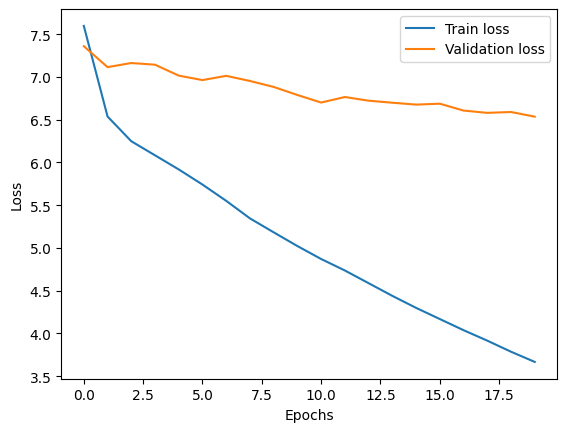

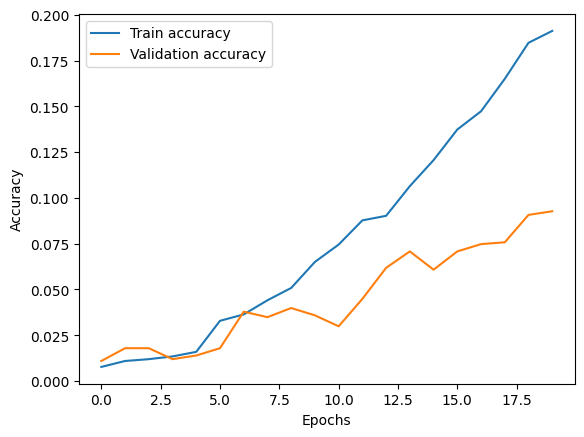

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Dense, LSTM, Reshape, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from time import time

gpu_devices = tf.config.list_physical_devices('GPU')
print(gpu_devices)

x, y = get_resource_df(student_vle_df, student_info_df, vle_df, sample_size=student_info_df.shape[0])
print(x.shape)
print(y.shape)
model = Sequential()
model.add(TimeDistributed(Dense(256, activation='relu'), input_shape=(7, 6421))) # TODO Try adding an Embedding layer and removing the other features
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(6364, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])

h = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2)
plt.figure()
plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
# save the plot as a png file named as loss_datetime.png
plt.savefig(f"graphs/loss_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")

plt.figure()
plt.plot(h.history['accuracy'], label='Train accuracy')
plt.plot(h.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(f"graphs/accuracy_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")


In [60]:
x, y = get_resource_df(student_vle_df, student_info_df, vle_df, sample_size=5000)
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Convert to PyTorch tensors
x = torch.tensor(x, dtype=torch.float32)  # (batch, seq, num_resources + meta_dim)
y = torch.tensor(y, dtype=torch.float32)  # (batch, num_resources)

x_test = torch.tensor(x_test, dtype=torch.float32)  # (batch, seq, num_resources + meta_dim)
y_test = torch.tensor(y_test, dtype=torch.float32)

Encoding student resources: 100%|██████████| 764/764 [00:36<00:00, 20.69it/s]


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Hyperparams
num_resources = 6364
meta_dim = 57
embed_dim = 128
meta_out_dim = 32
lstm_hidden_dim = 128
seq_len = 7



# Split input into resource IDs and metadata
resource_onehot = torch.tensor(x[:, :, :num_resources], dtype=torch.float32)       # (batch, seq, 6436)
print(resource_onehot.shape)
metadata = torch.tensor(x[:, :, num_resources:], dtype=torch.float32)              # (batch, seq, 57)
print(metadata.shape)
resource_ids = torch.argmax(resource_onehot, dim=-1)  # (batch, seq)

# Define layers
resource_embedding = nn.Embedding(num_resources, embed_dim)
metadata_dense = nn.Linear(meta_dim, meta_out_dim)
lstm = nn.LSTM(input_size=embed_dim + meta_out_dim, hidden_size=lstm_hidden_dim, batch_first=True)
output_layer = nn.Linear(lstm_hidden_dim, num_resources)

# Forward pass
resource_embed = resource_embedding(resource_ids)                   # (batch, seq, embed_dim)
metadata_embed = F.relu(metadata_dense(metadata))                  # (batch, seq, meta_out_dim)
lstm_input = torch.cat([resource_embed, metadata_embed], dim=-1)   # (batch, seq, embed + meta)

lstm_out, _ = lstm(lstm_input)             # (batch, seq, hidden_dim)
final_output = lstm_out[:, -1, :]          # (batch, hidden_dim)
pred = torch.sigmoid(output_layer(final_output))  # (batch, 6436)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([
    *resource_embedding.parameters(),
    *metadata_dense.parameters(),
    *lstm.parameters(),
    *output_layer.parameters()
], lr=0.001)

loss = criterion(pred, torch.tensor(y, dtype=torch.float32))
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Loss:", loss.item())

# test accuracy
with torch.no_grad():
    pred = torch.sigmoid(output_layer(lstm_out[:, -1, :]))
    predicted = torch.topk(pred, k=1, dim=-1).indices
    print(predicted)
    y = torch.topk(torch.tensor(y, dtype=torch.float32), k=1, dim=-1).indices
    print(y)
    correct = (predicted == y).float().sum()
    accuracy = correct / y.shape[0]
    print(f"Accuracy: {accuracy}")

torch.Size([2466, 7, 6364])
torch.Size([2466, 7, 57])
Loss: 0.6973896622657776
tensor([[5561],
        [2042],
        [5587],
        ...,
        [1885],
        [1885],
        [1885]])
tensor([[6224],
        [6207],
        [6145],
        ...,
        [4731],
        [5008],
        [4661]])
Accuracy: 0.0


In [36]:
# Run inference
with torch.no_grad():
    pred = torch.sigmoid(output_layer(lstm_out[:, -1, :]))
    top_preds = torch.topk(pred, k=5, dim=-1)
    print("Top 5 predictions:", top_preds.indices)

Top 5 predictions: tensor([[2681, 2120,  634,  328, 1512],
        [2681, 2030, 3330, 1512,  634],
        [3330, 5142, 2681, 5969,  328],
        ...,
        [2681,  634, 2776, 1512, 5428],
        [2681,  328, 1027, 5481, 5067],
        [2681,  527, 5142, 3466, 3330]])


# Class Implementation of a pytorch LSTM

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [85]:
class Predictor(nn.Module):
  NUM_RESOURCES = 6364
  META_DIM = 57
  EMBED_DIM = 128
  META_OUT_DIM = 32
  LSTM_HIDDEN_DIM = 128
  SEQ_LEN = 7
  def __init__(self, num_resources = NUM_RESOURCES, meta_dim = META_DIM,
               embed_dim = EMBED_DIM, meta_out_dim = META_OUT_DIM, lstm_hidden_dim = LSTM_HIDDEN_DIM):
    super(Predictor, self).__init__()
    self.num_resources = num_resources
    self.meta_dim = meta_dim

    weights = torch.rand(num_resources, embed_dim)

    self.resource_embedding = nn.Embedding(num_resources, embed_dim, _weight=weights)
    self.metadata_dense = nn.Linear(meta_dim, meta_out_dim)
    self.lstm = nn.LSTM(input_size=embed_dim + meta_out_dim, hidden_size=lstm_hidden_dim, batch_first=True)
    self.output_layer = nn.Linear(lstm_hidden_dim, num_resources)

  def forward(self, x):
    resource_onehot = x[:, :, :self.num_resources]
    metadata = x[:, :, self.num_resources:]
    resource_ids = torch.argmax(resource_onehot, dim=-1)
    resource_embeds = self.resource_embedding(resource_ids)
    metadata_encoded = F.relu(self.metadata_dense(metadata))
    lstm_input = torch.cat([resource_embeds, metadata_encoded], dim=-1)
    lstm_out, _ = self.lstm(lstm_input)
    final_hidden = lstm_out[:, -1, :]
    pred = torch.sigmoid(self.output_layer(final_hidden))
    return pred

In [86]:
def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_samples = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            preds = model.forward(x_batch)
            loss = loss_fn(preds, y_batch)

            total_loss += loss.item() * x_batch.size(0)

            top_k_preds = torch.topk(preds, k=1, dim=-1).indices
            y_batch = torch.topk(y_batch, k=1, dim=-1).indices
            print(top_k_preds)
            print(y_batch)
            # Binary accuracy (threshold 0.5)
            predicted = (preds > 0.5).float()
            correct = (predicted == y_batch).float().sum()
            total_acc += correct
            total_samples += y_batch.numel()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_acc / total_samples
    print(f"Evaluation — Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    return avg_loss, avg_acc


In [87]:
x, y = get_resource_df(student_vle_df, student_info_df, vle_df, sample_size=1000)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x, y), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size = 32)

Encoding student resources: 100%|██████████| 144/144 [00:07<00:00, 20.32it/s]


In [88]:


model = Predictor()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = [], [], []

NUM_EPOCHS = 20
for epoch in range(20):
  print(f"Epoch: {epoch}")

  loss = 0
  for x_batch, y_batch in train_loader:
    optimizer.zero_grad()
    preds = model(x_batch)
    loss = criterion(preds, y_batch)
    loss.backward()
    optimizer.step()
    loss += loss.item()

  val_loss, val_acc = evaluate_model(model, val_loader, criterion)
  train_losses.append(loss / len(train_loader))
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)
  print(f"Epoch {epoch+1} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch: 0
tensor([[5640],
        [6159],
        [6159],
        [6159],
        [6159],
        [5640],
        [6159],
        [3171],
        [6159],
        [6159],
        [3171],
        [5640],
        [6159],
        [3171],
        [6159],
        [5640],
        [ 124],
        [3171],
        [5640],
        [6159],
        [5640],
        [3171],
        [5640],
        [5640],
        [3171],
        [6159],
        [6159],
        [5640],
        [6159],
        [6159],
        [6159],
        [6159]])
tensor([[6092],
        [1243],
        [ 640],
        [4789],
        [5163],
        [6184],
        [2038],
        [6250],
        [5596],
        [4641],
        [6097],
        [6007],
        [1009],
        [6027],
        [4613],
        [6023],
        [6283],
        [6013],
        [1363],
        [1635],
        [5672],
        [5997],
        [6231],
        [6023],
        [6286],
        [1172],
        [ 522],
        [6172],
        [5289],
        [5793]

# TODO For Future

- Explore Pytorch's Embedding bag class for Recommender Systems.

# TODO For Debug

- Check embedding layer after a forward pass
- Check Metadata layer
- Check variabilitiy in y_train

# Testing

- Hold out a test
- Find a better Resource features

### Compiling LSTM Architecture

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

te = TransactionEncoder()
padded_resource_sets = pad_resource_sets(resources_sets)

# TODO this seems impossible

# Todo for any itemset (eg. A, B, C) find all the students that have this itemset and check their labels

padded_sequence, labels = get_sets_labels(padded_resource_sets)

te.fit(padded_sequence)
padded_sequence = te.transform(padded_sequence)

unique_ids = np.unique(padded_resource_sets.flatten())

# print(unique_ids.shape)

id_to_index = {id: index for index, id in enumerate(unique_ids)}
index_to_id = {index: id for index, id in enumerate(unique_ids)}


vectorized_map = np.vectorize(id_to_index.get)
tokenized_resource_sequence = vectorized_map(padded_resource_sets)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=np.unique(labels).shape[0])


# drop last element from every list in tokenized_resource_sequence
tokenized_resource_sequence = np.delete(tokenized_resource_sequence, -1, axis=1)

print(tokenized_resource_sequence)
# One-hot encode the labels


vocab_size = np.unique(padded_resource_sets.flatten()).shape[0]
embedding_dim = 64

model = Sequential()

model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(tokenized_resource_sequence.shape)
print(labels.shape)
model.fit(tokenized_resource_sequence, labels, epochs=10, batch_size=32, validation_split=0.4)

